In [6]:
import sys
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, box
import json
import time
import matplotlib.pyplot as plt

# Add src to path
sys.path.insert(0, os.path.abspath('../src'))

# Import required modules
from geometry import calculate_roof_area, calculate_roof_orientation
from solar import calculate_solar_potential, calculate_roi, calculate_payback_period
from shading import calculate_shading_factor, find_nearby_buildings, calculate_shadow_length
from spatial_search import SpatialIndex, binary_search_building_by_score, quicksort_buildings, find_top_k_buildings
from ranking import calculate_suitability_score, classify_building_suitability, rank_buildings, get_priority_list

print("✓ All modules imported successfully")

✓ All modules imported successfully


## 1. Geometric Analysis

### Test Roof Area Calculation

In [7]:
# Load processed buildings from notebook 01 (using TEST dataset for faster execution)
print("Loading processed TEST building data...")

buildings_gdf = gpd.read_file("../data/processed_test_buildings.json")

print(f"✅ Loaded {len(buildings_gdf)} buildings (TEST dataset)")
print(f"\nColumns: {list(buildings_gdf.columns)}")

# Test geometric calculations on sample buildings
print("\n🔬 Testing Geometric Calculations:")
print("=" * 60)

sample_buildings = buildings_gdf.head(5)
for idx, building in sample_buildings.iterrows():
    roof_area = calculate_roof_area(building.geometry)
    orientation = calculate_roof_orientation(building.geometry)
    
    print(f"\nBuilding {idx}:")
    print(f"  Roof area: {roof_area:.2f} m²")
    print(f"  Orientation: {orientation:.1f}°")
    print(f"  Geometry type: {building.geometry.geom_type}")

print("\n✅ Geometric analysis complete!")

Loading processed TEST building data...
✅ Loaded 3324 buildings (TEST dataset)

Columns: ['fid', 'b3_h_50p', 'b3_h_70p', 'b3_h_max', 'b3_h_min', 'b3_dd_id', 'identificatie', 'b3_pand_deel_id', 'b3_bag_bag_overlap', 'b3_n_vlakken', 'b3_pw_onvoldoende', 'b3_t_run', 'b3_h_nok', 'b3_n_nok', 'b3_extrusie', 'b3_is_glas_dak', 'b3_dak_type', 'b3_h_maaiveld', 'b3_kas_warenhuis', 'b3_mutatie_ahn3_ahn4', 'b3_mutatie_ahn4_ahn5', 'b3_nodata_fractie_ahn3', 'b3_nodata_fractie_ahn4', 'b3_nodata_fractie_ahn5', 'b3_nodata_radius_ahn3', 'b3_nodata_radius_ahn4', 'b3_nodata_radius_ahn5', 'b3_opp_buitenmuur', 'b3_opp_dak_plat', 'b3_opp_dak_schuin', 'b3_opp_grond', 'b3_opp_scheidingsmuur', 'b3_puntdichtheid_ahn3', 'b3_puntdichtheid_ahn4', 'b3_puntdichtheid_ahn5', 'b3_pw_bron', 'b3_pw_datum', 'b3_pw_selectie_reden', 'b3_rmse_lod12', 'b3_rmse_lod13', 'b3_rmse_lod22', 'b3_val3dity_lod12', 'b3_val3dity_lod13', 'b3_val3dity_lod22', 'b3_volume_lod12', 'b3_volume_lod13', 'b3_volume_lod22', 'b3_bouwlagen', 'b3_kwali

## 2. Solar Energy Calculations

### Mathematical Formula

$$E = A \times H \times \eta \times (1 - S)$$

Where:
- $E$ = Energy production (kWh)
- $A$ = Roof area (m²)
- $H$ = Solar irradiance (kWh/m²/year)
- $\eta$ = Panel efficiency (%)
- $S$ = Shading factor (0-1)

Loading solar irradiance data...
Yearly irradiation: 1000.00 kWh/m²/year

🔬 Testing Solar Energy Calculations:

Small roof, no shading:
  Roof area: 50 m²
  Panel efficiency: 20%
  Shading factor: 0%
  → Energy production: 10,000 kWh/year

Medium roof, 10% shading:
  Roof area: 100 m²
  Panel efficiency: 20%
  Shading factor: 10%
  → Energy production: 18,000 kWh/year

Large roof, 20% shading:
  Roof area: 200 m²
  Panel efficiency: 22%
  Shading factor: 20%
  → Energy production: 35,200 kWh/year

Very large roof, high efficiency:
  Roof area: 500 m²
  Panel efficiency: 25%
  Shading factor: 5%
  → Energy production: 118,750 kWh/year


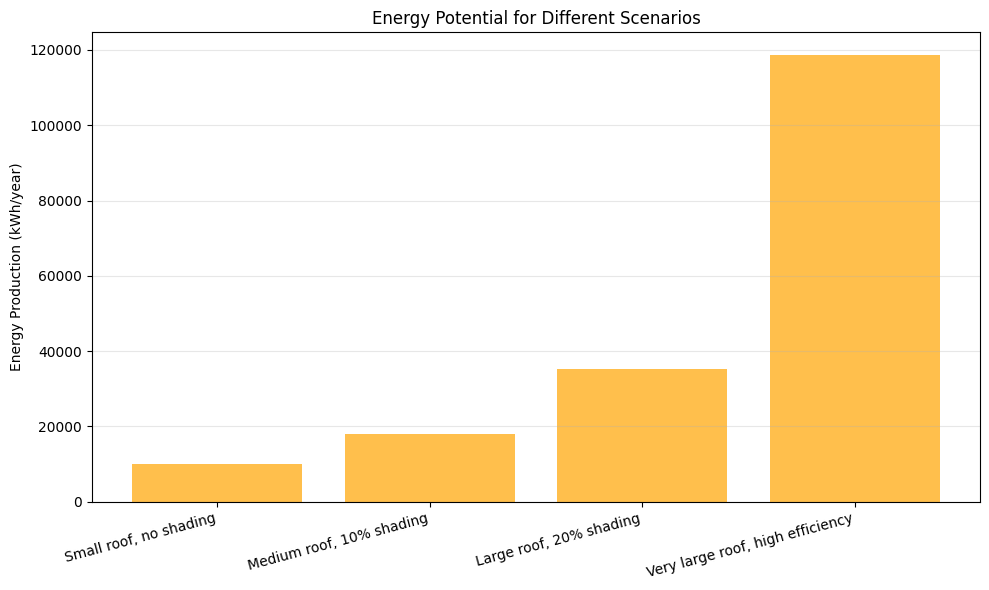


✅ Solar energy calculations complete!


In [8]:
# Load solar data and calculate energy potential for buildings
print("Loading solar irradiance data...")

with open("../data/test_solar.json", 'r') as f:
    solar_data = json.load(f)

yearly_irradiation = solar_data.get('yearly_irradiation', 1000)  # kWh/m²/year

print(f"Yearly irradiation: {yearly_irradiation:.2f} kWh/m²/year")

# Calculate energy potential for different scenarios
print("\n🔬 Testing Solar Energy Calculations:")
print("=" * 60)

# Test different roof sizes, panel efficiencies, and shading factors
test_scenarios = [
    {'roof_area': 50, 'efficiency': 0.20, 'shading': 0.0, 'label': 'Small roof, no shading'},
    {'roof_area': 100, 'efficiency': 0.20, 'shading': 0.1, 'label': 'Medium roof, 10% shading'},
    {'roof_area': 200, 'efficiency': 0.22, 'shading': 0.2, 'label': 'Large roof, 20% shading'},
    {'roof_area': 500, 'efficiency': 0.25, 'shading': 0.05, 'label': 'Very large roof, high efficiency'},
]

results = []
for scenario in test_scenarios:
    energy = calculate_solar_potential(
        area=scenario['roof_area'],
        irradiance=yearly_irradiation,
        efficiency=scenario['efficiency'],
        shading_factor=scenario['shading']
    )
    
    results.append({
        'scenario': scenario['label'],
        'energy_kwh': energy
    })
    
    print(f"\n{scenario['label']}:")
    print(f"  Roof area: {scenario['roof_area']} m²")
    print(f"  Panel efficiency: {scenario['efficiency']*100:.0f}%")
    print(f"  Shading factor: {scenario['shading']*100:.0f}%")
    print(f"  → Energy production: {energy:,.0f} kWh/year")

# Visualize scenarios
fig, ax = plt.subplots(figsize=(10, 6))
scenarios = [r['scenario'] for r in results]
energies = [r['energy_kwh'] for r in results]
ax.bar(scenarios, energies, color='orange', alpha=0.7)
ax.set_ylabel('Energy Production (kWh/year)')
ax.set_title('Energy Potential for Different Scenarios')
plt.xticks(rotation=15, ha='right')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\n✅ Solar energy calculations complete!")

## 3. ROI Analysis

### Mathematical Formula

$$ROI = \frac{E \times Price - Cost}{Cost} \times 100\%$$

In [9]:
# Calculate ROI and payback period
print("🔬 Testing ROI Analysis:")
print("=" * 60)

# Economic parameters
electricity_price = 0.25  # €/kWh
installation_cost_per_m2 = 150  # €/m²

for scenario in test_scenarios:
    energy = calculate_solar_potential(
        area=scenario['roof_area'],
        irradiance=yearly_irradiation,
        efficiency=scenario['efficiency'],
        shading_factor=scenario['shading']
    )
    
    # Calculate effective panel area (usable roof area)
    panel_area = scenario['roof_area'] * 0.8  # 80% of roof is usable
    
    roi = calculate_roi(
        energy_kwh=energy,
        energy_price=electricity_price,
        installation_cost_per_m2=installation_cost_per_m2,
        area=panel_area
    )
    
    payback = calculate_payback_period(
        energy_kwh=energy,
        energy_price=electricity_price,
        installation_cost_per_m2=installation_cost_per_m2,
        area=panel_area
    )
    
    print(f"\n{scenario['label']}:")
    print(f"  Energy: {energy:,.0f} kWh/year")
    print(f"  Installation cost: €{panel_area * installation_cost_per_m2:,.0f}")
    print(f"  Annual savings: €{energy * electricity_price:,.0f}")
    print(f"  ROI (20 years): {roi:.1f}%")
    print(f"  Payback period: {payback:.1f} years")

print("\n✅ ROI analysis complete!")

🔬 Testing ROI Analysis:

Small roof, no shading:
  Energy: 10,000 kWh/year
  Installation cost: €6,000
  Annual savings: €2,500
  ROI (20 years): -58.3%
  Payback period: 2.4 years

Medium roof, 10% shading:
  Energy: 18,000 kWh/year
  Installation cost: €12,000
  Annual savings: €4,500
  ROI (20 years): -62.5%
  Payback period: 2.7 years

Large roof, 20% shading:
  Energy: 35,200 kWh/year
  Installation cost: €24,000
  Annual savings: €8,800
  ROI (20 years): -63.3%
  Payback period: 2.7 years

Very large roof, high efficiency:
  Energy: 118,750 kWh/year
  Installation cost: €60,000
  Annual savings: €29,688
  ROI (20 years): -50.5%
  Payback period: 2.0 years

✅ ROI analysis complete!


## 4. Shadow Analysis

🔬 Testing Shadow Analysis:

Calculating shading factors for all buildings...
✅ Calculated shading for 3324 buildings

📊 Shading Analysis Results:
Mean shading factor: 0.003
Median shading factor: 0.000
Buildings with no shading: 3092
Buildings with >50% shading: 0


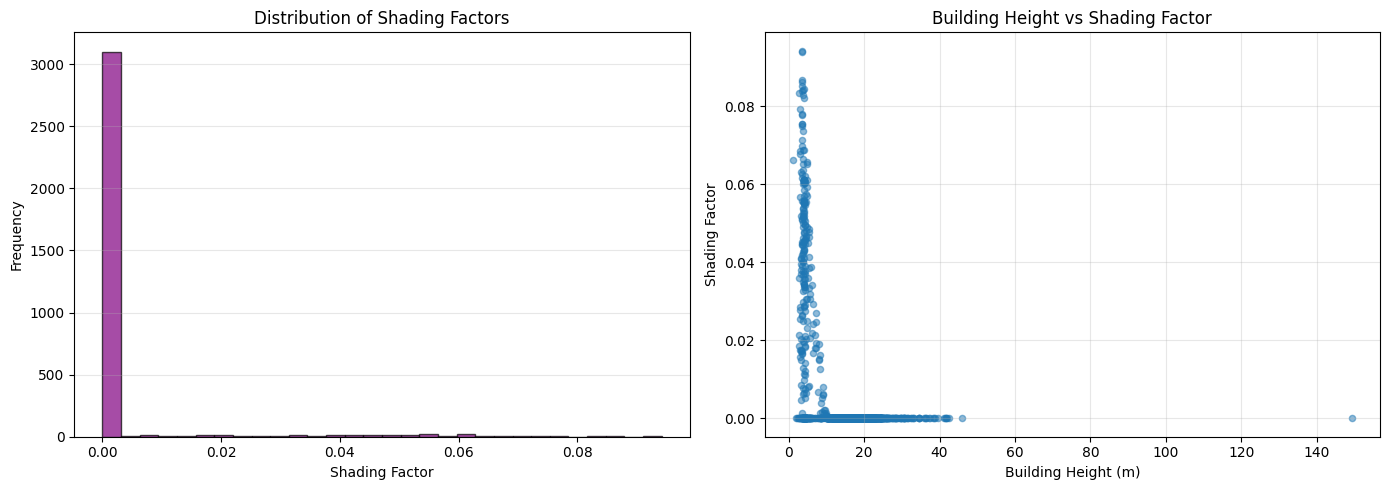


✅ Shading analysis complete! Data saved to test_buildings_with_shading.json


In [11]:
# Calculate shading factors for buildings
print("🔬 Testing Shadow Analysis:")
print("=" * 60)

# Ensure buildings have height data
if 'b3_h_max' not in buildings_gdf.columns or buildings_gdf['b3_h_max'].isna().all():
    print("⚠️ No height data available, using default values")
    buildings_gdf['b3_h_max'] = 10.0  # Default height

# Perform shading analysis for each building
print("\nCalculating shading factors for all buildings...")
search_radius = 50.0  # 50m search radius for neighboring buildings
shading_factors = []

for idx, building in buildings_gdf.iterrows():
    # Find nearby buildings
    nearby = find_nearby_buildings(
        building.geometry,
        buildings_gdf,
        search_radius=search_radius
    )
    
    # Calculate shading factor
    shading = calculate_shading_factor(
        building_geometry=building.geometry,
        building_height=building.get('b3_h_max', 10.0),
        nearby_buildings=nearby,
        sun_elevation=45.0  # Average sun elevation
    )
    
    shading_factors.append(shading)

# Add shading factor to dataframe
buildings_gdf['shading_factor'] = shading_factors
buildings_with_shading = buildings_gdf.copy()

print(f"✅ Calculated shading for {len(buildings_gdf)} buildings")

# Statistics
print(f"\n📊 Shading Analysis Results:")
print(f"Mean shading factor: {buildings_with_shading['shading_factor'].mean():.3f}")
print(f"Median shading factor: {buildings_with_shading['shading_factor'].median():.3f}")
print(f"Buildings with no shading: {(buildings_with_shading['shading_factor'] == 0).sum()}")
print(f"Buildings with >50% shading: {(buildings_with_shading['shading_factor'] > 0.5).sum()}")

# Visualize shading distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(buildings_with_shading['shading_factor'], bins=30, color='purple', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Shading Factor')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Shading Factors')
axes[0].grid(True, alpha=0.3, axis='y')

# Scatter plot: height vs shading
axes[1].scatter(buildings_with_shading['b3_h_max'], 
                buildings_with_shading['shading_factor'], 
                alpha=0.5, s=20)
axes[1].set_xlabel('Building Height (m)')
axes[1].set_ylabel('Shading Factor')
axes[1].set_title('Building Height vs Shading Factor')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save shading data
buildings_with_shading.to_file("../data/test_buildings_with_shading.json", driver="GeoJSON")
print("\n✅ Shading analysis complete! Data saved to test_buildings_with_shading.json")

# Update buildings_gdf for next steps
buildings_gdf = buildings_with_shading

## 5. Spatial Search Algorithms

### KD-tree for Nearest Neighbor Search

🔬 Testing KD-Tree Nearest Neighbor Search:

Building KD-tree spatial index for 3324 buildings...
✅ KD-tree built in 14.03 ms

Finding 5 nearest neighbors to building 0...
Search time: 1.79 ms

Nearest 5 buildings:
  1. Building 0: 0.00 m away
  2. Building 4: 3.03 m away
  3. Building 6: 11.00 m away
  4. Building 2: 13.40 m away
  5. Building 37: 15.57 m away


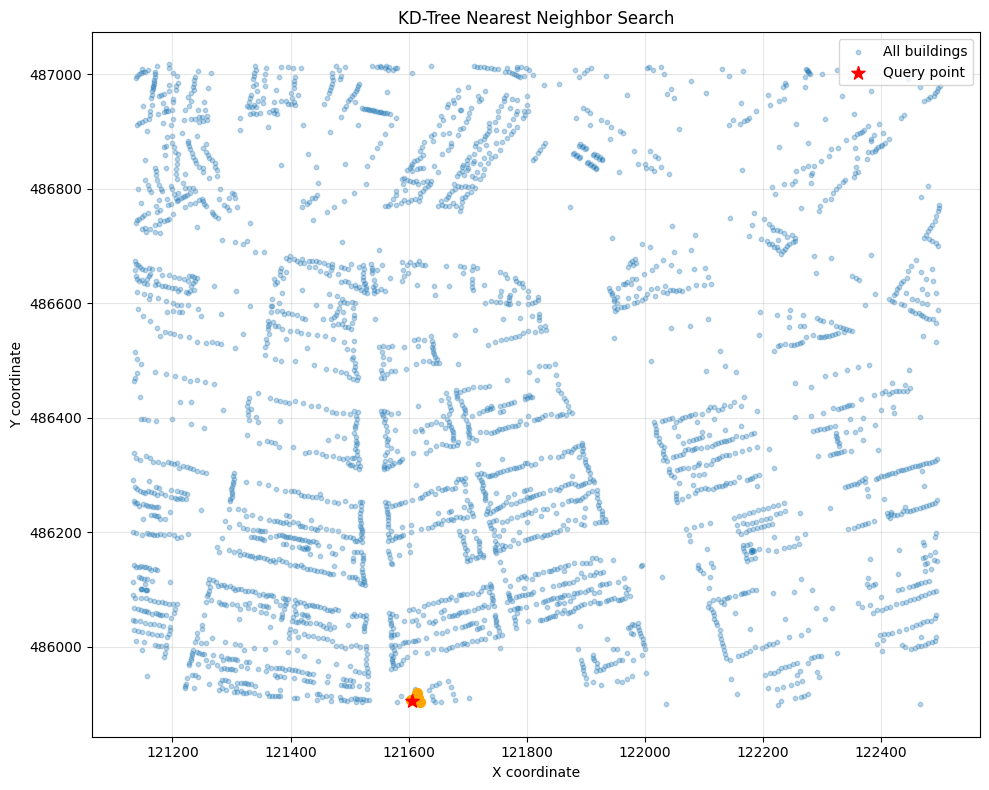


✅ KD-tree search complete!


In [14]:
# Test KD-tree nearest neighbor search
print("🔬 Testing KD-Tree Nearest Neighbor Search:")
print("=" * 60)

# Build spatial index using SpatialIndex class
print(f"\nBuilding KD-tree spatial index for {len(buildings_gdf)} buildings...")
start_time = time.time()
spatial_index = SpatialIndex(buildings_gdf)
build_time = time.time() - start_time
print(f"✅ KD-tree built in {build_time*1000:.2f} ms")

# Test nearest neighbor search
test_building = buildings_gdf.iloc[0]
test_point = test_building.geometry.centroid
k = 5

print(f"\nFinding {k} nearest neighbors to building 0...")
start_time = time.time()
nearest_buildings = spatial_index.find_nearest_neighbors(test_point, k=k)
search_time = time.time() - start_time
print(f"Search time: {search_time*1000:.2f} ms")

print(f"\nNearest {k} buildings:")
for i, (idx, row) in enumerate(nearest_buildings.iterrows()):
    dist = row['distance']
    print(f"  {i+1}. Building {idx}: {dist:.2f} m away")

# Visualize
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))

# Extract centroids for plotting
centroids = np.array([[geom.centroid.x, geom.centroid.y] for geom in buildings_gdf.geometry])

ax.scatter(centroids[:, 0], centroids[:, 1], alpha=0.3, s=10, label='All buildings')
ax.scatter(test_point.x, test_point.y, color='red', s=100, marker='*', label='Query point', zorder=5)

# Plot nearest neighbors (skip first if it's the same building)
for idx, row in nearest_buildings.iloc[1:].iterrows():
    centroid = row.geometry.centroid
    ax.scatter(centroid.x, centroid.y, color='orange', s=50, marker='o', zorder=4)

ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.set_title('KD-Tree Nearest Neighbor Search')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ KD-tree search complete!")

### Binary Search for Score Threshold

In [17]:
# Test binary search for score threshold
print("🔬 Testing Binary Search for Score Threshold:")
print("=" * 60)

# Create sample scores (sorted) in a DataFrame
sample_scores = np.array([50, 60, 65, 70, 75, 80, 82, 85, 88, 90, 92, 95, 97, 98, 100])
print(f"\nSample scores (sorted): {sample_scores}")

# Create a simple DataFrame for testing binary search
test_df = pd.DataFrame({
    'suitability_score': sample_scores,
    'building_id': range(len(sample_scores))
})

# Test different thresholds
thresholds = [75, 85, 95]

for threshold in thresholds:
    idx = binary_search_building_by_score(test_df, threshold, 'suitability_score')
    print(f"\nThreshold: {threshold}")
    print(f"  Index: {idx}")
    print(f"  Buildings with score >= {threshold}: {len(sample_scores) - idx}")
    if idx < len(sample_scores):
        print(f"  First building above threshold: score = {sample_scores[idx]}")

print("\n✅ Binary search test complete!")

🔬 Testing Binary Search for Score Threshold:

Sample scores (sorted): [ 50  60  65  70  75  80  82  85  88  90  92  95  97  98 100]

Threshold: 75
  Index: 4
  Buildings with score >= 75: 11
  First building above threshold: score = 75

Threshold: 85
  Index: 7
  Buildings with score >= 85: 8
  First building above threshold: score = 85

Threshold: 95
  Index: 11
  Buildings with score >= 95: 4
  First building above threshold: score = 95

✅ Binary search test complete!


### Quicksort Algorithm

🔬 Testing Quicksort Algorithm:

Sorting 1000 random scores...

Quicksort time: 6.507 ms
NumPy sort time: 0.175 ms
Speedup: 37.23x

✅ Sorting correct: True


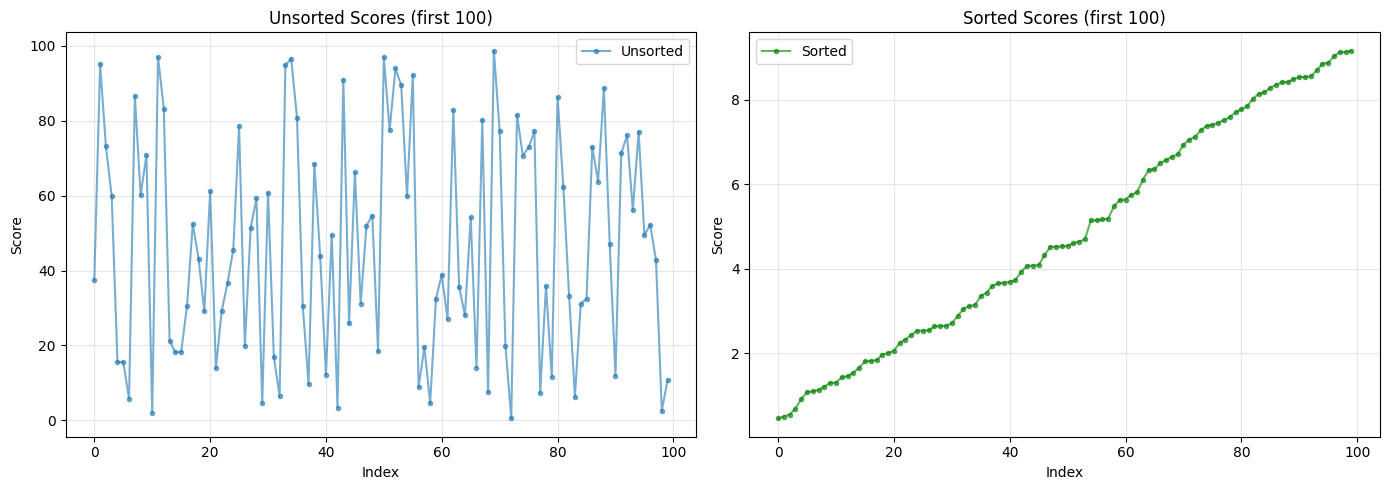


✅ Quicksort test complete!


In [19]:
# Test quicksort algorithm performance
print("🔬 Testing Quicksort Algorithm:")
print("=" * 60)

# Generate random scores
np.random.seed(42)
n_buildings = 1000
random_scores = np.random.uniform(0, 100, n_buildings)

print(f"\nSorting {n_buildings} random scores...")

# Create DataFrame for testing quicksort
test_gdf = gpd.GeoDataFrame({
    'score': random_scores,
    'building_id': range(n_buildings)
})

# Time quicksort
start_time = time.time()
sorted_gdf_quick = quicksort_buildings(test_gdf, sort_column='score', ascending=True)
quicksort_time = time.time() - start_time

# Compare with numpy sort
start_time = time.time()
sorted_scores_numpy = np.sort(random_scores.copy())
numpy_time = time.time() - start_time

print(f"\nQuicksort time: {quicksort_time*1000:.3f} ms")
print(f"NumPy sort time: {numpy_time*1000:.3f} ms")
print(f"Speedup: {quicksort_time/numpy_time:.2f}x")

# Verify correctness
sorted_scores_quick = sorted_gdf_quick['score'].values
is_correct = np.allclose(sorted_scores_quick, sorted_scores_numpy)
print(f"\n✅ Sorting correct: {is_correct}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(random_scores[:100], 'o-', alpha=0.6, markersize=3, label='Unsorted')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Score')
axes[0].set_title('Unsorted Scores (first 100)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(sorted_scores_quick[:100], 'o-', alpha=0.6, markersize=3, color='green', label='Sorted')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Score')
axes[1].set_title('Sorted Scores (first 100)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Quicksort test complete!")

## 6. Suitability Scoring and Ranking

In [26]:
# Calculate energy potential with shading factors
print("🔬 Calculating Energy Potential with Shading:")
print("=" * 60)

# Use solar irradiance from earlier (or load it)
if 'yearly_irradiation' not in dir():
    with open("../data/test_solar.json", 'r') as f:
        solar_data = json.load(f)
    yearly_irradiation = solar_data.get('yearly_irradiation', 1000)

print(f"Using yearly irradiation: {yearly_irradiation:.2f} kWh/m²/year")

# Ensure orientation column exists (calculate if missing)
if 'orientation' not in buildings_gdf.columns:
    print("\n⚠️ Orientation column missing, calculating now...")
    buildings_gdf['orientation'] = buildings_gdf.geometry.apply(calculate_roof_orientation)
    print("✅ Orientation calculated")

# Calculate energy potential for each building
panel_efficiency = 0.20  # 20% efficient panels
buildings_gdf['energy_potential'] = buildings_gdf.apply(
    lambda row: calculate_solar_potential(
        area=row['roof_area'],
        irradiance=row.get('solar_irradiance', yearly_irradiation),
        efficiency=panel_efficiency,
        shading_factor=row.get('shading_factor', 0.0)
    ),
    axis=1
)

print(f"✅ Calculated energy potential for {len(buildings_gdf)} buildings")
print(f"\nEnergy Potential Statistics:")
print(f"Mean: {buildings_gdf['energy_potential'].mean():,.0f} kWh/year")
print(f"Median: {buildings_gdf['energy_potential'].median():,.0f} kWh/year")
print(f"Total: {buildings_gdf['energy_potential'].sum() / 1000:,.2f} MWh/year")

🔬 Calculating Energy Potential with Shading:
Using yearly irradiation: 1000.00 kWh/m²/year
✅ Calculated energy potential for 3324 buildings

Energy Potential Statistics:
Mean: 28,725 kWh/year
Median: 13,635 kWh/year
Total: 95,482.16 MWh/year


🔬 Calculating Suitability Scores:

Calculating suitability scores...
Classifying buildings...

📊 Suitability Score Statistics:
Mean score: 49.25
Median score: 45.50
Min score: 20.10
Max score: 99.96

📊 Suitability Classification:
Excellent   :  324 buildings (9.7%)
Good        :  327 buildings (9.8%)
Moderate    : 1513 buildings (45.5%)
Poor        : 1160 buildings (34.9%)


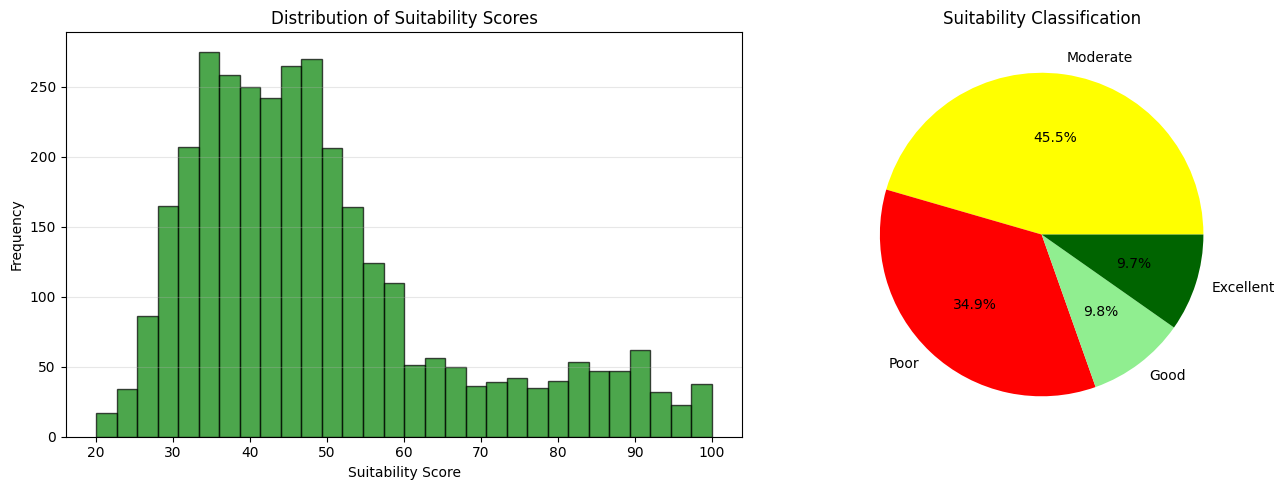


✅ Suitability analysis complete! Data saved to test_buildings_with_solar_analysis.json


In [27]:
# Calculate suitability scores and classify
print("🔬 Calculating Suitability Scores:")
print("=" * 60)

# Ensure all required columns exist
if 'orientation' not in buildings_gdf.columns:
    print("\n⚠️ Orientation column missing, calculating now...")
    buildings_gdf['orientation'] = buildings_gdf.geometry.apply(calculate_roof_orientation)
    print("✅ Orientation calculated")

if 'energy_potential' not in buildings_gdf.columns:
    print("\n❌ ERROR: energy_potential column missing!")
    print("Please run the previous cell to calculate energy potential first.")
    raise ValueError("Missing required column: energy_potential")

# Calculate scores
print("\nCalculating suitability scores...")
buildings_gdf['suitability_score'] = buildings_gdf.apply(
    lambda row: calculate_suitability_score(
        roof_area=row['roof_area'],
        energy_potential=row['energy_potential'],
        orientation=row['orientation'],
        shading_factor=row.get('shading_factor', 0.0)
    ),
    axis=1
)

# Classify suitability
print("Classifying buildings...")
buildings_gdf['suitability_class'] = buildings_gdf['suitability_score'].apply(classify_building_suitability)

# Statistics
print(f"\n📊 Suitability Score Statistics:")
print(f"Mean score: {buildings_gdf['suitability_score'].mean():.2f}")
print(f"Median score: {buildings_gdf['suitability_score'].median():.2f}")
print(f"Min score: {buildings_gdf['suitability_score'].min():.2f}")
print(f"Max score: {buildings_gdf['suitability_score'].max():.2f}")

print(f"\n📊 Suitability Classification:")
unique_classes = buildings_gdf['suitability_class'].unique()
for cls in sorted(unique_classes, key=lambda x: ['Excellent', 'Good', 'Moderate', 'Fair', 'Poor'].index(x) if x in ['Excellent', 'Good', 'Moderate', 'Fair', 'Poor'] else 999):
    count = (buildings_gdf['suitability_class'] == cls).sum()
    pct = (count / len(buildings_gdf)) * 100
    print(f"{cls:12s}: {count:4d} buildings ({pct:.1f}%)")

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Score distribution
axes[0].hist(buildings_gdf['suitability_score'], bins=30, color='green', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Suitability Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Suitability Scores')
axes[0].grid(True, alpha=0.3, axis='y')

# Classification pie chart with comprehensive color mapping
class_counts = buildings_gdf['suitability_class'].value_counts()
colors_map = {
    'Excellent': 'darkgreen',
    'Good': 'lightgreen',
    'Moderate': 'yellow',
    'Fair': 'orange',
    'Poor': 'red'
}
# Use .get() with default color for any unexpected classes
pie_colors = [colors_map.get(cls, 'gray') for cls in class_counts.index]
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', colors=pie_colors)
axes[1].set_title('Suitability Classification')

plt.tight_layout()
plt.show()

# Save data
buildings_gdf.to_file("../data/test_buildings_with_solar_analysis.json", driver="GeoJSON")
print("\n✅ Suitability analysis complete! Data saved to test_buildings_with_solar_analysis.json")

## 7. Priority Ranking

In [28]:
# Rank buildings and get top priority candidates
print("🔬 Ranking Buildings by Priority:")
print("=" * 60)

# Rank all buildings
ranked_buildings = rank_buildings(buildings_gdf)

# Get top 20 (since this is test data)
top_20 = ranked_buildings.head(20)

print(f"\n📊 Top 20 Priority Buildings (TEST dataset):")
print(f"Suitability scores: {top_20['suitability_score'].min():.2f} - {top_20['suitability_score'].max():.2f}")
print(f"Total roof area: {top_20['roof_area'].sum() / 1000:.2f} thousand m²")
print(f"Total energy potential: {top_20['energy_potential'].sum() / 1000:.2f} MWh/year")

# Display top 10
print(f"\n🏆 Top 10 Priority Buildings:")
print(ranked_buildings[['rank', 'roof_area', 'energy_potential', 'orientation', 
                        'shading_factor', 'suitability_score', 'suitability_class']].head(10))

# Save ranked data
ranked_buildings.to_file("../data/ranked_test_buildings.json", driver="GeoJSON")
top_20.to_file("../data/top_20_test_buildings.json", driver="GeoJSON")

# Summary statistics
summary = {
    'total_buildings': int(len(ranked_buildings)),
    'top_20_stats': {
        'total_roof_area_m2': float(top_20['roof_area'].sum()),
        'total_energy_potential_kwh': float(top_20['energy_potential'].sum()),
        'avg_suitability_score': float(top_20['suitability_score'].mean()),
        'min_score': float(top_20['suitability_score'].min()),
        'max_score': float(top_20['suitability_score'].max())
    },
    'excellent_buildings': int((ranked_buildings['suitability_class'] == 'Excellent').sum()),
    'good_buildings': int((ranked_buildings['suitability_class'] == 'Good').sum())
}

with open("../data/test_ranking_summary.json", 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\n✅ Ranking complete! Results saved to:")
print(f"   - ../data/ranked_test_buildings.json")
print(f"   - ../data/top_20_test_buildings.json")
print(f"   - ../data/test_ranking_summary.json")

print(f"\n🎉 Algorithm development complete!")
print(f"Ready for visualization in notebook 03! 🚀")

🔬 Ranking Buildings by Priority:

📊 Top 20 Priority Buildings (TEST dataset):
Suitability scores: 98.57 - 99.96
Total roof area: 26.70 thousand m²
Total energy potential: 4562.71 MWh/year

🏆 Top 10 Priority Buildings:
      rank    roof_area  energy_potential  orientation  shading_factor  \
2086     1  3251.185337     555712.104925   180.377247             0.0   
2299     2   839.878696     143542.387879   184.255238             0.0   
2842     3   584.102167      99828.051049   184.759684             0.0   
2868     4  1300.743354     222308.124264   174.664851             0.0   
2843     5  1076.992809     184067.258418   174.444293             0.0   
3033     6   641.286893     109601.183100   174.323872             0.0   
2196     7   667.324556     114061.162702   187.812729             0.0   
2963     8  1865.505991     318831.056937   188.568411             0.0   
2295     9  1799.244858     307506.327628   190.703899             0.0   
187     10   622.477059     106387.453720 

## Next Steps

1. ✅ Algorithms tested and validated
2. ✅ Move to notebook 03 for visualization
3. ✅ Create choropleth maps and interactive visualizations